In [3]:
import numpy as np

In [4]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [61]:
dataset = datasets.load_iris()
X = dataset.data
Y = dataset.target
#for i in range(X.shape[1]):
#    X[:, i] = level(X[:, i])
feature_names = dataset.feature_names
class_names = dataset.target_names
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)


In [82]:
def entropy(Y, possible_classes):
    entropy = 0
    total_count = len(Y)
    for y in possible_classes :
        count_y = (Y == y).sum()
        p_i = count_y/total_count
        entropy -=  p_i * np.log(p_i)
    return entropy

def info_gain_for_cont_data_split(Y, splits):
    info_gain = 0
    split_info = 0    
    mod_Y = len(Y)
    unique_splits = list(set(splits))
    for s in unique_splits:
        indices = (splits == s)
        Y_split_i = Y[indices]
        #print([X_split_i, Y_split_i])
        mod_Y_i = len(Y_split_i)
        ratio_mod_Y_i_to_mod_Y = (mod_Y_i/mod_Y)
        possible_classes_Y_i = list(set(Y_split_i))
        info_gain += ((ratio_mod_Y_i_to_mod_Y) * entropy( Y_split_i, possible_classes_Y_i))
        split_info -= (ratio_mod_Y_i_to_mod_Y * np.log(ratio_mod_Y_i_to_mod_Y))
    return info_gain, split_info

"""
def split(X, Y, feature):
    possible_values_current_feature = list(set( X[:, feature] ))
    pvcf = possible_values_current_feature
    mid_values = []
    
    for i in range(len(possible_values_current_feature) -1 ):
        mid_values.append((pvcf[i] + pvcf[i+1])/2)
    max_info_gain = -np.inf
    mid_value_for_max_info_gain = 0
    max_split_info = 0
    best_split_labels = np.array([])
    for value in mid_values:
        current_split_labels = np.zeros(len(Y))
        current_split_labels[ X[:, feature] <= value ] = 1
        current_split_information_gain, current_split_split_info = info_gain_for_cont_data_split(Y, current_split_labels)
        #print(current_split_information_gain)
        if current_split_information_gain > max_info_gain :
            max_info_gain = current_split_information_gain
            mid_value_for_max_info_gain = value
            max_split_info = current_split_split_info
            best_split_labels = current_split_labels
    #print("min_info_gain, min_split_info, best_split_labels, mid_value_for_min_info_gain")
    #print(min_info_gain, min_split_info, best_split_labels, mid_value_for_min_info_gain)
    
    return max_info_gain, max_split_info, best_split_labels.astype(int), mid_value_for_max_info_gain
"""

def split(X, Y, feature):
    possible_values_current_feature = list(set( X[:, feature] ))
    pvcf = possible_values_current_feature
    mid_values = []
    
    for i in range(len(possible_values_current_feature) -1 ):
        mid_values.append((pvcf[i] + pvcf[i+1])/2)
    min_info_gain = np.inf
    mid_value_for_min_info_gain = 0
    min_split_info = 0
    best_split_labels = []
    for value in mid_values:
        current_split_labels = np.zeros(len(Y))
        current_split_labels[ X[:, feature] <= value ] = 1
        current_split_information_gain, current_split_split_info = info_gain_for_cont_data_split(Y, current_split_labels)
        #print(current_split_information_gain)
        if current_split_information_gain < min_info_gain :
            min_info_gain = current_split_information_gain
            mid_value_for_min_info_gain = value
            min_split_info = current_split_split_info
            best_split_labels = current_split_labels
    #print("min_info_gain, min_split_info, best_split_labels, mid_value_for_min_info_gain")
    #print(min_info_gain, min_split_info, best_split_labels, mid_value_for_min_info_gain)
    
    return min_info_gain, min_split_info, best_split_labels.astype(int), mid_value_for_min_info_gain



    
def decision_tree(X, Y, features, feature_names, level):
    node = {}
    node["level"] = level
    class_counts = {}
    print("\nLevel", level)
    possible_classes = list(set(Y))
    max_count = -np.inf
    max_class = possible_classes[0]
    for y in possible_classes:
        count_y = (Y == y).sum()
        class_counts[y] = count_y
        print("Count of", y, "=", count_y)
        if count_y > max_count :
            max_count = count_y
            max_class = y   
    current_entropy = entropy(Y, possible_classes)
    print("Current Entropy is =", current_entropy)
    
    node['class_counts'] = class_counts
    node["Entropy"] = current_entropy
    
    if len(possible_classes) == 1 or len(features) == 0:
        print("Reached leaf Node")
        node["is_leaf"] = True
        node["predict_class"] = max_class
        return node
    node["is_leaf"] = False
    selected_feature = None
    max_info_gain = -np.inf
    best_split_labels = None
    best_split_mid_value = None
    for f in features:
        info_gain, split_info, current_split, current_mid_value_for_f = split(X, Y, f)
        #print("info_gain, split_info", info_gain, split_info)
        #print("gain ratio", info_gain/split_info)

        if info_gain > max_info_gain:
            selected_feature = f
            max_info_gain = info_gain
            best_split_labels = current_split
            best_split_mid_value = current_mid_value_for_f
    
    node["selected_feature"] = selected_feature
    node["max_info_gain"] = max_info_gain
    node["best_split_mid_value"] = best_split_mid_value
    node["num_of_examples"] = len(Y)
    
    print("Splitting on feature", selected_feature,"with gain ratio", max_info_gain)
    #splits = split(X, Y, selected_feature)
    unique_splits = list(set(best_split_labels))
    
    selected_feature_index = np.argwhere(features == selected_feature)
    features =  np.delete(features, selected_feature_index)
    
    for s in unique_splits:
        indices = (best_split_labels == s)
        X_split_i = X[indices, :]
        Y_split_i = Y[indices]
        node[s] = decision_tree(X_split_i, Y_split_i, features, feature_names, level + 1)
    return node
#print(split(X, Y, 0))
      
    
features = np.arange(len(feature_names))
tree_dict = decision_tree(X_train, Y_train, features, feature_names, level = 0)


Level 0
Count of 0 = 35
Count of 1 = 41
Count of 2 = 36
Current Entropy is = 1.09617459744
Splitting on feature 1 with gain ratio 0.900146657736

Level 1
Count of 0 = 34
Count of 1 = 12
Count of 2 = 19
Current Entropy is = 1.01039529699
Splitting on feature 0 with gain ratio 0.430680500763

Level 2
Count of 1 = 9
Count of 2 = 19
Current Entropy is = 0.62794158874
Splitting on feature 3 with gain ratio 0.14179660239

Level 3
Count of 1 = 1
Count of 2 = 19
Current Entropy is = 0.198515243346
Splitting on feature 2 with gain ratio 0.069314718056

Level 4
Count of 2 = 18
Current Entropy is = 0.0
Reached leaf Node

Level 4
Count of 1 = 1
Count of 2 = 1
Current Entropy is = 0.69314718056
Reached leaf Node

Level 3
Count of 1 = 8
Current Entropy is = 0.0
Reached leaf Node

Level 2
Count of 0 = 34
Count of 1 = 3
Current Entropy is = 0.281401839591
Splitting on feature 2 with gain ratio 0.0

Level 3
Count of 1 = 3
Current Entropy is = 0.0
Reached leaf Node

Level 3
Count of 0 = 34
Current Entr

In [83]:
def predict_single(X, tree_dict):
    if tree_dict['is_leaf']:
        return tree_dict["predict_class"]
    index = tree_dict["selected_feature"]
    feature_value = tree_dict["best_split_mid_value"]

    #print("Feature:", feature_names[index])
    #print("Feature Value:", feature_value)
    
    if X[index] <= feature_value :
        #print(X[index], "<=" ,feature_value)
        return predict_single(X, tree_dict[0])
    else :
        #print(X[index], ">" ,feature_value)
        return predict_single(X, tree_dict[1])

def predict(X, tree_dict):
    Y_pred = []
    for i in range(len(X)):
        Y_pred.append(predict_single(X[i], tree_dict))
    return Y_pred

def print_dict(dictionary, level = 0):
    for key in dictionary:
        if isinstance(dictionary[key], dict) :
            print(key, end = " ")
            print_dict(dictionary[key], level + 1)
        else:
            print(key, dictionary[key])


print_dict(tree_dict)


level 0
class_counts 0 35
1 41
2 36
Entropy 1.09617459744
is_leaf False
selected_feature 1
max_info_gain 0.900146657736
best_split_mid_value 2.9
num_of_examples 112
0 level 1
class_counts 0 34
1 12
2 19
Entropy 1.01039529699
is_leaf False
selected_feature 0
max_info_gain 0.430680500763
best_split_mid_value 5.8
num_of_examples 65
0 level 2
class_counts 1 9
2 19
Entropy 0.62794158874
is_leaf False
selected_feature 3
max_info_gain 0.14179660239
best_split_mid_value 1.75
num_of_examples 28
0 level 3
class_counts 1 1
2 19
Entropy 0.198515243346
is_leaf False
selected_feature 2
max_info_gain 0.069314718056
best_split_mid_value 4.95
num_of_examples 20
0 level 4
class_counts 2 18
Entropy 0.0
is_leaf True
predict_class 2
1 level 4
class_counts 1 1
2 1
Entropy 0.69314718056
is_leaf True
predict_class 1
1 level 3
class_counts 1 8
Entropy 0.0
is_leaf True
predict_class 1
1 level 2
class_counts 0 34
1 3
Entropy 0.281401839591
is_leaf False
selected_feature 2
max_info_gain 0.0
best_split_mid_value 2

In [84]:
for i in range(len(X)):
    print("Example", i, ":", X[i])
    pred = predict_single(X[i], tree_dict)

    print("\tActual Class:", Y[i])
    print("\tPredicted Class:", pred)


Example 0 : [ 5.1  3.5  1.4  0.2]
	Actual Class: 0
	Predicted Class: 0
Example 1 : [ 4.9  3.   1.4  0.2]
	Actual Class: 0
	Predicted Class: 0
Example 2 : [ 4.7  3.2  1.3  0.2]
	Actual Class: 0
	Predicted Class: 2
Example 3 : [ 4.6  3.1  1.5  0.2]
	Actual Class: 0
	Predicted Class: 2
Example 4 : [ 5.   3.6  1.4  0.2]
	Actual Class: 0
	Predicted Class: 0
Example 5 : [ 5.4  3.9  1.7  0.4]
	Actual Class: 0
	Predicted Class: 0
Example 6 : [ 4.6  3.4  1.4  0.3]
	Actual Class: 0
	Predicted Class: 2
Example 7 : [ 5.   3.4  1.5  0.2]
	Actual Class: 0
	Predicted Class: 0
Example 8 : [ 4.4  2.9  1.4  0.2]
	Actual Class: 0
	Predicted Class: 2
Example 9 : [ 4.9  3.1  1.5  0.1]
	Actual Class: 0
	Predicted Class: 0
Example 10 : [ 5.4  3.7  1.5  0.2]
	Actual Class: 0
	Predicted Class: 0
Example 11 : [ 4.8  3.4  1.6  0.2]
	Actual Class: 0
	Predicted Class: 0
Example 12 : [ 4.8  3.   1.4  0.1]
	Actual Class: 0
	Predicted Class: 0
Example 13 : [ 4.3  3.   1.1  0.1]
	Actual Class: 0
	Predicted Class: 2
Ex

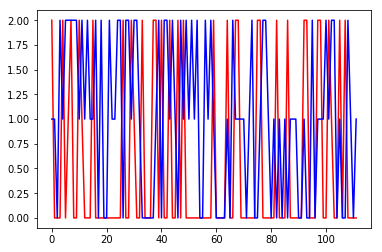

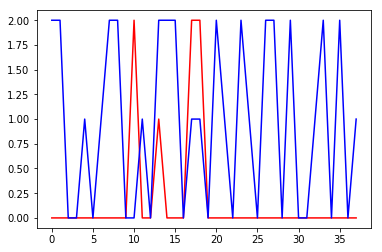

In [85]:
import matplotlib.pyplot as plt
Y_train_pred = predict(X_train, tree_dict)
plt.plot(Y_train_pred, color = "r")
plt.plot(Y_train, color = "b")
plt.show()

Y_test_pred = predict(X_test, tree_dict)
plt.plot(Y_test_pred, color = "r")
plt.plot(Y_test, color = "b")
plt.show()

In [89]:
from sklearn.metrics import confusion_matrix
print("Confusion Matrix for Y_train\n", confusion_matrix(Y_train, Y_train_pred))
print("Confusion Matrix for Y_test\n", confusion_matrix(Y_test, Y_test_pred))

Confusion Matrix for Y_train
 [[25  0 10]
 [23  0 18]
 [31  4  1]]
Confusion Matrix for Y_test
 [[14  0  1]
 [ 7  0  2]
 [13  1  0]]


array([[ 0, 15,  0],
       [ 0,  7,  2],
       [ 0, 14,  0]], dtype=int64)